In [1]:
import tensorflow  as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
IMG_SIZE = 176
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 60

In [4]:
# Loadin the datasets in 32 batches.
training_data = tf.keras.preprocessing.image_dataset_from_directory(
    "drive/MyDrive/alzheimer_new_Dataset/train",
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

testing_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "drive/MyDrive/alzheimer_new_Dataset/test",
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 5131 files belonging to 4 classes.
Found 1279 files belonging to 4 classes.


In [5]:
# Storin the class names.
class_names = training_data.class_names
print(class_names)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


### **`Data Exploration`**
- Data Exploration step includes the various operations including data visualization, data partitions and so on.

In [6]:
# Data exploration.
# Taking the 1 batch of 32 images.
print("--- Training Data Exploration ---")
for image_batch, label_batch in training_data.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

print("--- Testing Data Exploration ---")
for image_batch, label_batch in testing_dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

--- Training Data Exploration ---
(32, 176, 176, 3)
[3 0 2 2 3 3 2 0 3 2 3 2 2 0 3 2 2 2 2 3 0 2 2 2 2 0 2 2 3 2 2 3]
--- Testing Data Exploration ---
(32, 176, 176, 3)
[2 2 0 3 2 3 2 3 2 2 2 2 2 2 3 2 2 3 3 3 2 2 0 0 2 2 3 3 2 2 2 0]


---- Data Visualization from training dataset ----


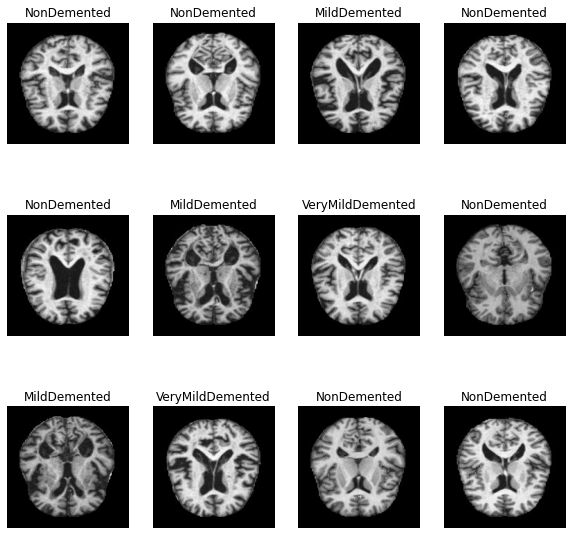

In [7]:
# Data Visulaization (I know how my dataset is look like but as a Gujarati Zhansa to marana padega....:)).
print("---- Data Visualization from training dataset ----")
plt.figure(figsize=(10, 10))
for image_batch, label_batch in training_data.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

---- Data Visualization from testing dataset ----


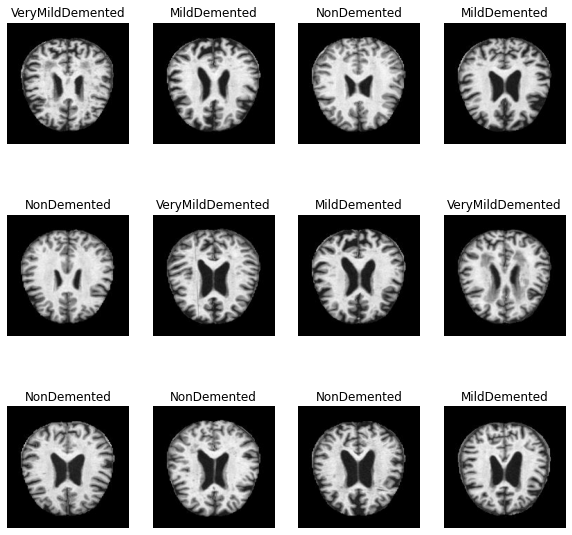

In [8]:
print("---- Data Visualization from testing dataset ----")
plt.figure(figsize=(10, 10))
for image_batch, label_batch in testing_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

### We have separate data of training and testing, we just need to spitout the validation dataset from training instance.

In [9]:
# A function which will splitout our dataset.
def dataset_partitions(training_data, train_split=0.8, validation_split=0.2, shuffle=True, shuffle_size=10000):
    # Asserting images just because user/developer cannot split data with wrong points of splitting.
    assert (train_split + validation_split) == 1

    # Dataset size.
    dataset_size = len(training_data)

    # Shuffling the data.
    if shuffle:
        training_data = training_data.shuffle(shuffle_size, seed=12)
    
    # Actual splitting the dataset.
    training_size = int(train_split*dataset_size)
    validation_size = int(validation_split*dataset_size)

    training_dataset = training_data.take(training_size)
    validation_dataset = training_data.skip(training_size).take(validation_size)

    return training_dataset, validation_dataset


In [10]:
# Getting partitions done.
training_dataset, validation_dataset = dataset_partitions(training_data)

In [11]:
# Just checking that dataset is properly splitted or not!
print("Training Length : ", len(training_dataset))
print("Validation Length : ", len(validation_dataset))
print("Testing Length : ", len(testing_dataset))

Training Length :  128
Validation Length :  32
Testing Length :  40


### **Model Creation**

In [12]:
# We will add some additional worj including data augmentation, image resizing and rescaling and many more thing.
training_dataset = training_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
testing_dataset = testing_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
# Lets do resizing and rescaling opearation.
resize_and_rescale = tf.keras.Sequential([
    keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
# Transformaing the data image and creating transformated samples.
data_augmentation = tf.keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [15]:
# Now, Let's create a model using trail and error.
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)
n_classes = 4

model = keras.models.Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(IMG_SIZE,IMG_SIZE,3),
                   pooling='avg',classes=4,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

model.add(pretrained_model)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(n_classes, activation='softmax'))

model.build(input_shape=input_shape)

94781440/94765736 [==============================] - 1s 0us/step


In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                                 
Total params: 24,702,980
Trainable params: 1,115,268
Non-trainable params: 23,587,712
_________________________________________________________________


In [17]:
early_stopping = keras.callbacks.EarlyStopping(patience=5)

In [18]:
CALLBACKS = [early_stopping]

model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [20]:
history = model.fit(training_dataset, batch_size=BATCH_SIZE, callbacks=[CALLBACKS], epochs=EPOCHS, validation_data=validation_dataset)

Epoch 1/60
128/128 [==============================] - 40s 313ms/step - loss: 1.0637 - accuracy: 0.5153 - val_loss: 0.8973 - val_accuracy: 0.5723
Epoch 2/60
128/128 [==============================] - 29s 226ms/step - loss: 0.8637 - accuracy: 0.5872 - val_loss: 0.8178 - val_accuracy: 0.5992
Epoch 3/60
128/128 [==============================] - 29s 226ms/step - loss: 0.8351 - accuracy: 0.6083 - val_loss: 0.7756 - val_accuracy: 0.6381
Epoch 4/60
128/128 [==============================] - 29s 226ms/step - loss: 0.7561 - accuracy: 0.6439 - val_loss: 0.7969 - val_accuracy: 0.6291
Epoch 5/60
128/128 [==============================] - 29s 226ms/step - loss: 0.7378 - accuracy: 0.6638 - val_loss: 0.6881 - val_accuracy: 0.6959
Epoch 6/60
128/128 [==============================] - 29s 226ms/step - loss: 0.6894 - accuracy: 0.6940 - val_loss: 0.6572 - val_accuracy: 0.7059
Epoch 7/60
128/128 [==============================] - 29s 227ms/step - loss: 0.6477 - accuracy: 0.6996 - val_loss: 0.6154 - val_ac

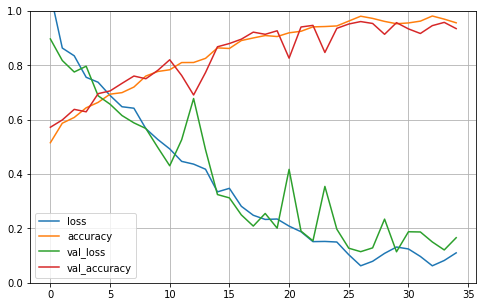

In [23]:
# Plotting Accuracy, Loss, Validation Accuracy and Validation loss.\n",
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [24]:
model.evaluate(testing_dataset)

40/40 [==============================] - 86s 213ms/step - loss: 1.7635 - accuracy: 0.6200


[1.7635338306427002, 0.6200156211853027]

In [ ]:
model.save("model_resnet50.h5")

Actual Image Class : Non Demented (AD)
Actual Image Class : Non Demented (AD)


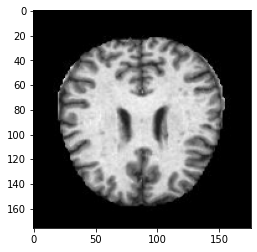

In [40]:
# Let's try to predict image.
for images_batch, labels_batch in testing_dataset.take(1):
  first_image = images_batch[0].numpy().astype('uint8')
  plt.imshow(first_image)
  # print("Actual Actual Label : ", labels_batch[0].numpy())
  actual_class = labels_batch[0].numpy()
  if actual_class == 0:
    print("Image Class : Mild Demented (AD)")
  elif actual_class == 1:
    print("Actual Image Class : Moderate Demented (AD)")
  elif actual_class == 2:
    print("Actual Image Class : Non Demented (AD)")
  elif actual_class == 3:
    print("Actual Image Class : Very Mild Demented (AD)")

  batch_predictions = model.predict(images_batch)
  predicted_class = np.argmax(batch_predictions[0])
  if predicted_class == 0:
    print("Image Class : Mild Demented (AD)")
  elif predicted_class == 1:
    print("Predicted Image Class : Moderate Demented (AD)")
  elif predicted_class == 2:
    print("Predicted Image Class : Non Demented (AD)")
  elif predicted_class == 3:
    print("Predicted Image Class : Very Mild Demented (AD)")
  confidence = round(100 * (np.argmax(batch_predictions[0])), 2)
  # print(f"Confidence : " + str(confidence) + "%")

In [31]:
# And here is the model. I know that this is not the perfect model but >63% accuracy will not too bad.